#### Initialize

In [0]:
!python mlip_setup_env.py

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Notebook from Kaggle
But with WandB integration and tensorflow 2.0. Adapted from https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

%tensorflow_version 2.x
# from tensorflow import keras
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Weights and Biases integration
import wandb
from wandb.keras import WandbCallback

# import helper functions
from starter_eda_model_funcs import resize, get_dummies, get_model
from helper import GlobalAccuracyCallback, train, resize_padding

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print("Data files:")
for dirname, _, filenames in os.walk('Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

TensorFlow 2.x selected.
Data files:
Data/train_image_data_3.parquet
Data/test_image_data_2.parquet
Data/test_image_data_3.parquet
Data/test.csv
Data/train_image_data_0.parquet
Data/sample_submission.csv
Data/data
Data/train_image_data_1.parquet
Data/train_image_data_2.parquet
Data/test_image_data_0.parquet
Data/train.csv
Data/test_image_data_1.parquet
Data/class_map.csv
Data/prep/config.csv
Data/prep/part0.parquet
Data/prep/part2.parquet
Data/prep/part3.parquet
Data/prep/part1.parquet


In [0]:
# Any results you write to the current directory are saved as output.

train_df_ = pd.read_csv('Data/train.csv')
test_df_ = pd.read_csv('Data/test.csv')
class_map_df = pd.read_csv('Data/class_map.csv')
sample_sub_df = pd.read_csv('Data/sample_submission.csv')
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

# define original image size
HEIGHT = 137
WIDTH = 236
# define target image size
IMG_SIZE = 64
N_CHANNELS = 1
# define training parameters
batch_size = 256
epochs = 30

Size of training data: (200840, 4)
Size of test data: (36, 3)
Size of class map: (186, 3)
Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


# Padding

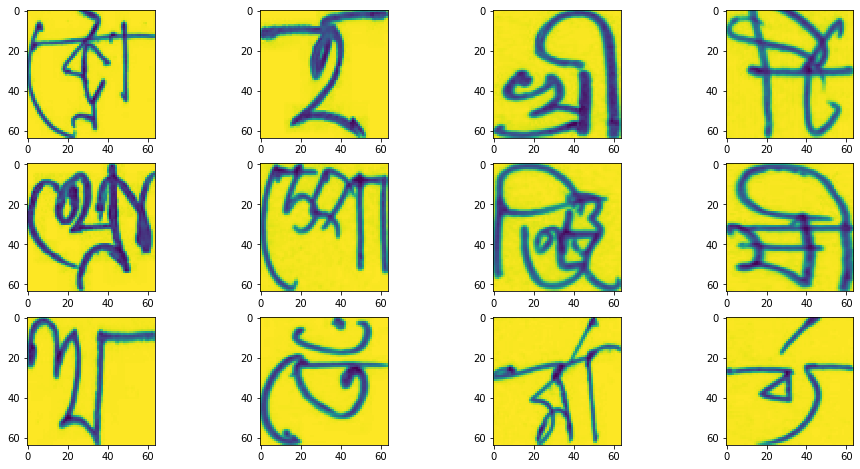


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 35s 195ms/step - loss: 12.5569 - out_root_loss: 4.6809 - out_vowel_loss: 1.9545 - out_consonant_loss: 1.2406 - out_root_acc: 0.0352 - out_vowel_acc: 0.2939 - out_consonant_acc: 0.6176 - val_loss: 12.3993 - val_out_root_loss: 4.6336 - val_out_vowel_loss: 1.8847 - val_out_consonant_loss: 1.2552 - val_out_root_acc: 0.0398 - val_out_vowel_acc: 0.3525 - val_out_consonant_acc: 0.6107
Epoch 2/30
180/180 [==============================] - 30s 167ms/step - loss: 10.9121 - out_root_loss: 4.2196 - out_vowel_loss: 1.3677 - out_consonant_loss: 1.1052 - out_root_acc: 0.0630 - out_vowel_acc: 0.5024 - out_consonant_acc: 0.6278 - val_loss: 10.3357 - val_out_root_l

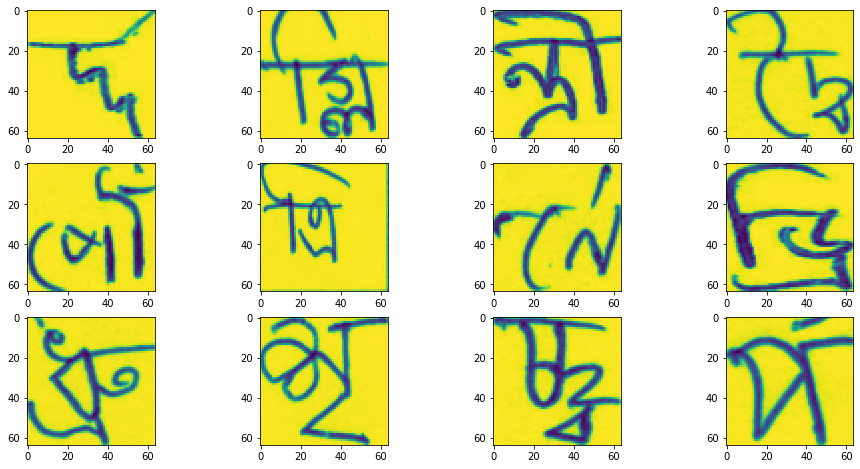


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 30s 165ms/step - loss: 1.3935 - out_root_loss: 0.5074 - out_vowel_loss: 0.2146 - out_consonant_loss: 0.1641 - out_root_acc: 0.8649 - out_vowel_acc: 0.9397 - out_consonant_acc: 0.9511 - val_loss: 0.7680 - val_out_root_loss: 0.2882 - val_out_vowel_loss: 0.1002 - val_out_consonant_loss: 0.0914 - val_out_root_acc: 0.9213 - val_out_vowel_acc: 0.9741 - val_out_consonant_acc: 0.9759
Epoch 2/30
180/180 [==============================] - 29s 163ms/step - loss: 1.1997 - out_root_loss: 0.4263 - out_vowel_loss: 0.1960 - out_consonant_loss: 0.1511 - out_root_acc: 0.8809 - out_vowel_acc: 0.9458 - out_consonant_acc: 0.9544 - val_loss: 0.7149 - val_out_root_loss:

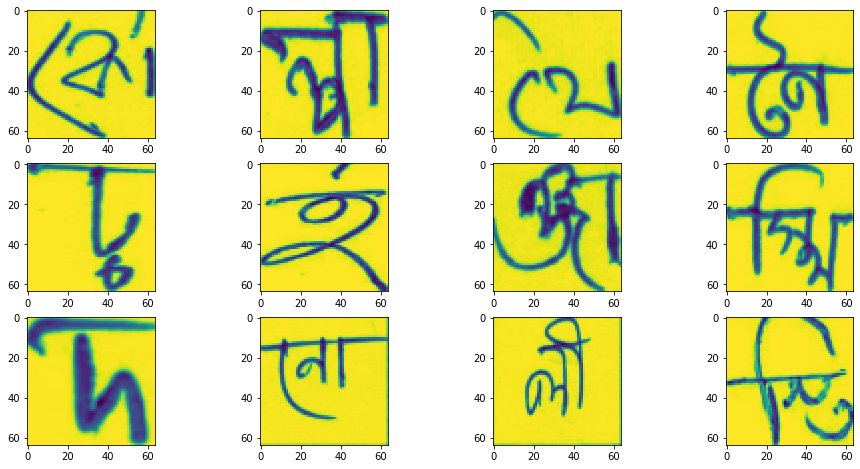


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 29s 163ms/step - loss: 0.8873 - out_root_loss: 0.3244 - out_vowel_loss: 0.1330 - out_consonant_loss: 0.1056 - out_root_acc: 0.9163 - out_vowel_acc: 0.9638 - out_consonant_acc: 0.9694 - val_loss: 0.5573 - val_out_root_loss: 0.2128 - val_out_vowel_loss: 0.0678 - val_out_consonant_loss: 0.0660 - val_out_root_acc: 0.9477 - val_out_vowel_acc: 0.9818 - val_out_consonant_acc: 0.9798
Epoch 2/30
180/180 [==============================] - 29s 160ms/step - loss: 0.7644 - out_root_loss: 0.2710 - out_vowel_loss: 0.1243 - out_consonant_loss: 0.0980 - out_root_acc: 0.9256 - out_vowel_acc: 0.9664 - out_consonant_acc: 0.9712 - val_loss: 0.5454 - val_out_root_loss:

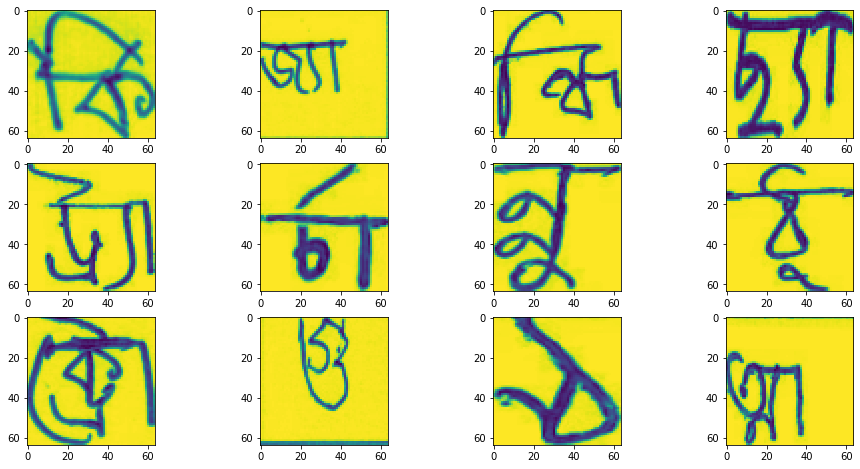


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 30s 166ms/step - loss: 0.7685 - out_root_loss: 0.2843 - out_vowel_loss: 0.1084 - out_consonant_loss: 0.0914 - out_root_acc: 0.9305 - out_vowel_acc: 0.9714 - out_consonant_acc: 0.9735 - val_loss: 0.5421 - val_out_root_loss: 0.2056 - val_out_vowel_loss: 0.0747 - val_out_consonant_loss: 0.0562 - val_out_root_acc: 0.9495 - val_out_vowel_acc: 0.9808 - val_out_consonant_acc: 0.9846
Epoch 2/30
180/180 [==============================] - 29s 162ms/step - loss: 0.7385 - out_root_loss: 0.2711 - out_vowel_loss: 0.1063 - out_consonant_loss: 0.0900 - out_root_acc: 0.9314 - out_vowel_acc: 0.9714 - out_consonant_acc: 0.9751 - val_loss: 0.5255 - val_out_root_loss:

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=64,
    padding=6,
)

model = get_model()
train(train_df_, datagen_args, name='Image 64, padding 6', model=model,
      preprocess_args=preprocess_args)

# Future

https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn/comments#719766  
*Paul Nussbaum, PhD wrote:*  
As I mentioned in an earlier post, I would like to see Keras someday include visualizations of the internal workings of CNN's, but until then, I have provided a notebook that does that, albeit crudely:

https://www.kaggle.com/pnussbaum/grapheme-mind-reader-panv12-nogpu   

The notebook allows you to see a picture of each of the Conv2D layer filters, as well as a picture re-creation of the original input image based on the output of that Conv2D layer.  

By looking at these images for the first few Conv2D layers, three problems were identified (see the bottom of the notebook), and I fixed one of these problems (that of too many filters in the second and third convolutional layers) in the following notebook:  

https://www.kaggle.com/pnussbaum/fork-of-bengali-graphemes-starter-eda-multi-outpu  

The ability to see the problems graphically, and fix them easily, improved the val_root_acc from just under .94 to just under .95  

I will now work on fixing the other two identified problems (low resolution losing detail, and detail close to the edge being lost after repeated convolutions) so wish me luck!

---


https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn/comments#722499  
*K.Amano wrote:*  
At first, I used three `learning_rate_reduction_xxx()` to imitate your Kernel, but when multiple `learning_rate_reduction_xxx()` worked at the same time, `lr` was reduced at once.  

Therefore, I currently only use `val_root_loss`, which seems to have the greatest impact (my Kernel: In[33]).  

In fact, I think that it is better to apply `val_loss (= val_root_loss * w + val_vowel_loss * w + val_consonant_loss * w)` to `learning_rate_reduction()` after setting `loss_weights` (In[24]) appropriately. However, I adjusted `loss_weights` to some extent, but did not get good results.


---


Format the data in such a way that the training loop can access all of the data, instead of just a quarter. Perhaps after resizing all even fits in memory?


----
https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn/comments#735320  
*Buffalo Spdwy wrote:*  
By the way, for the `keras.preprocessing.image.ImageDataGenerator`, the `fill_mode` defaults to be `nearest`. And since we are here clipping characters to the contour boundary, it causes "bleeding".   

Better:  
`fill_mode='constant', cval=1`

----

https://www.kaggle.com/iafoss/image-preprocessing-128x128

Especially the nice centering of the graphemes. 

## Larger image size and add padding


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


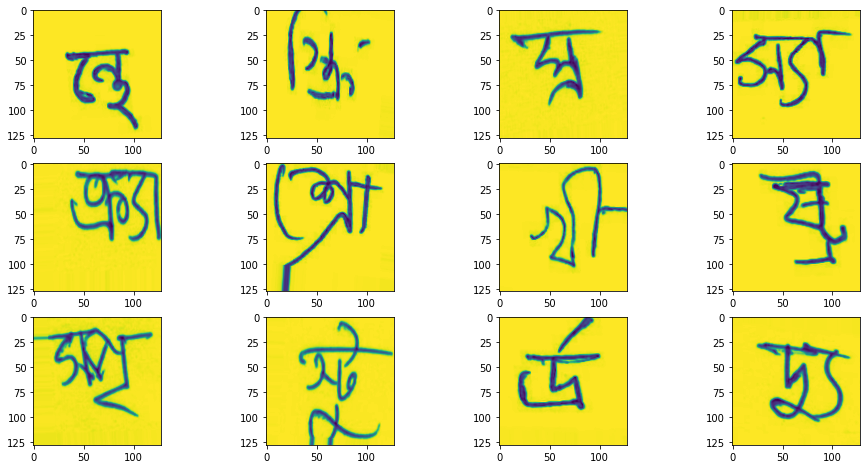

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 106s 589ms/step - loss: 12.5422 - out_root_loss: 4.7663 - out_vowel_loss: 1.7364 - out_consonant_loss: 1.2732 - out_root_acc: 0.0311 - out_vowel_acc: 0.4085 - out_consonant_acc: 0.6153 - val_loss: 12.6485 - val_out_root_loss: 4.6371 - val_out_vowel_loss: 2.0587 - val_out_consonant_loss: 1.3161 - val_out_root_acc: 0.0408 - val_out_vowel_acc: 0.3764 - val_out_consonant_acc: 0.5288
Epoch 2/30
180/180 [==============================] - 93s 516ms/step - loss: 10.5175 - out_root_loss: 4.2365 - out_vowel_loss: 1.0367 - out_consonant_loss: 1.0077 - out_root_acc: 0.0611 - out_vowel_acc: 0.6389 - out_consonant_acc: 0.6439 - val_loss: 8.9919 - val_out_root_loss: 3.7654 - val_out_vowel_loss: 0.6628 - val_out_consonant_loss: 0.7996 - val_out_root_acc: 0.1075 - val_out_vowel_acc: 0.7717 - val_out_consona

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=128,
    padding=28, # actual image 128-28*2 = 72x72, comparable to before
)

model = get_model(img_size=preprocess_args['image_size'])
train(train_df_, datagen_args, name='Image 128, padding 28', model=model,
      preprocess_args=preprocess_args)

### Retry


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


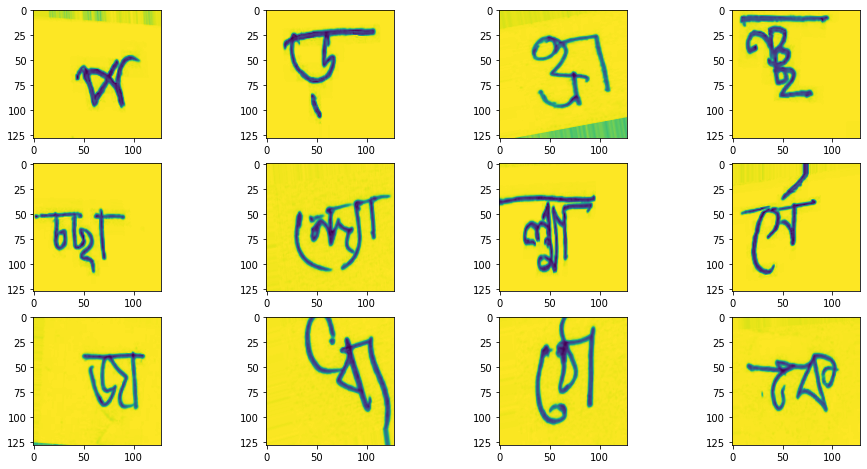

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 105s 581ms/step - loss: 12.5894 - out_root_loss: 4.7621 - out_vowel_loss: 1.8385 - out_consonant_loss: 1.2267 - out_root_acc: 0.0311 - out_vowel_acc: 0.3512 - out_consonant_acc: 0.6237 - val_loss: 11.3060 - val_out_root_loss: 4.5421 - val_out_vowel_loss: 1.1655 - val_out_consonant_loss: 1.0543 - val_out_root_acc: 0.0408 - val_out_vowel_acc: 0.5656 - val_out_consonant_acc: 0.6438
Epoch 2/30
180/180 [==============================] - 93s 514ms/step - loss: 10.8038 - out_root_loss: 4.3002 - out_vowel_loss: 1.1820 - out_consonant_loss: 1.0214 - out_root_acc: 0.0560 - out_vowel_acc: 0.5711 - out_consonant_acc: 0.6489 - val_loss: 9.6975 - val_out_root_loss: 4.0238 - val_out_vowel_loss: 0.7830 - val_out_consonant_loss: 0.8706 - val_out_root_acc: 0.0722 - val_out_vowel_acc: 0.7209 - val_out_consona

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=128,
    padding=32, # actual image 128-32*2 = 64x64, same as before
)

model = get_model(img_size=preprocess_args['image_size'])
train(train_df_, datagen_args, name='Image 128, padding 32', model=model,
      preprocess_args=preprocess_args)

# First prepare all images

In [0]:
from helper import perform_preprocessing

preprocess_args = dict(
    image_size=128,
    padding=32, # actual image 128-32*2 = 64x64, same as before
)

perform_preprocessing(train_df_, preprocess_args, parts=True)

/content/helper.py:278: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  pd.Series({'WARING': "Preprocessing unfinished"}).to_csv(f"{data_path}/{prep_folder}/config.csv")


STEP 1/4



STEP 2/4



STEP 3/4



STEP 4/4


/content/helper.py:309: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  pd.Series(preprocess_args).to_csv(f"{data_path}/{prep_folder}/config.csv")


In [0]:
# from helper import merge_preprocessing_parts
# # requires very much ram, >25GB
# merge_preprocessing_parts()

Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


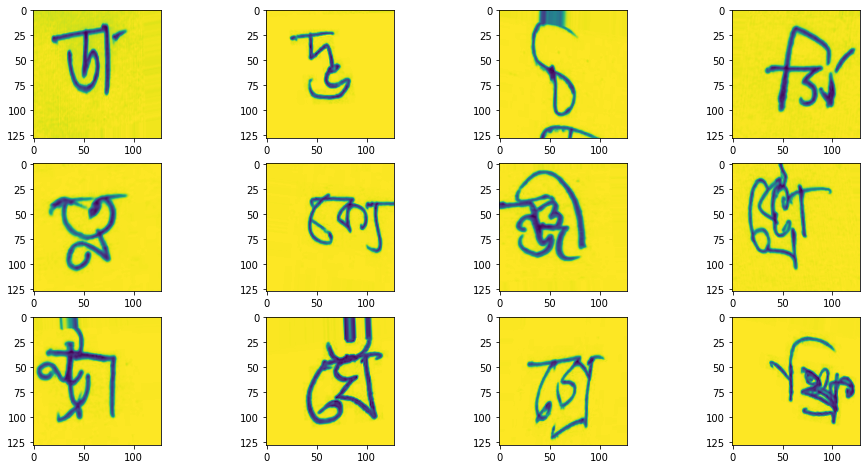

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 107s 595ms/step - loss: 12.6680 - out_root_loss: 4.7677 - out_vowel_loss: 1.8767 - out_consonant_loss: 1.2558 - out_root_acc: 0.0302 - out_vowel_acc: 0.3481 - out_consonant_acc: 0.6159 - val_loss: 12.0548 - val_out_root_loss: 4.6001 - val_out_vowel_loss: 1.8116 - val_out_consonant_loss: 1.0406 - val_out_root_acc: 0.0339 - val_out_vowel_acc: 0.3582 - val_out_consonant_acc: 0.6283
Epoch 2/30
180/180 [==============================] - 93s 517ms/step - loss: 10.7897 - out_root_loss: 4.3097 - out_vowel_loss: 1.2061 - out_consonant_loss: 0.9642 - out_root_acc: 0.0523 - out_vowel_acc: 0.5679 - out_consonant_acc: 0.6633 - val_loss: 10.0184 - val_out_root_loss: 4.0316 - val_out_vowel_loss: 1.1436 - val_out_consonant_loss: 0.8165 - val_out_root_acc: 0.0774 - val_out_vowel_acc: 0.5621 - val_out_conson

In [0]:
from helper import train_from_prep

datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=128,
    padding=32, # actual image 128-32*2 = 64x64, same as before
)

model = get_model(img_size=preprocess_args['image_size'])
train_from_prep(train_df_, datagen_args, name='Image 128, padding 32', model=model,
      preprocess_args=preprocess_args)

**Part 2**

In [0]:
import wandb
api = wandb.Api()
run = api.run("/joeranbosma/mlip/runs/ytnttq3h")
run.file("model-best.h5").download(replace=True)
print("Best model saved to model-best.h5")

Best model saved to model-best.h5


In [0]:
from tensorflow.keras.models import load_model
from starter_eda_model_funcs import get_lr_reduction_calbacks, MultiOutputDataGenerator
model = load_model('model-best.h5')

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=128,
    padding=32, # actual image 128-32*2 = 64x64, same as before
)
IMG_SIZE = preprocess_args['image_size']

In [0]:
# set up config
config = datagen_args.copy()
config['epochs'] = epochs
config['name'] = "Image 128, padding 32, part 2"
config.update(preprocess_args)
wandb.init(project='mlip', name=config['name'], config=config)

W&B Run: https://app.wandb.ai/joeranbosma/mlip/runs/93ftcixp

In [0]:
data_path = 'Data/'; prep_folder = 'prep/';

histories = []
for i in range(1, 4):
    train_df = pd.merge(pd.read_parquet(f'{data_path}/{prep_folder}/part{i}.parquet'), train_df_, left_index=True, right_on='image_id').drop(['image_id'], axis=1)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = train_df.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    del train_df

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    datagen = MultiOutputDataGenerator(**datagen_args)
    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)
    
    # create custom global accuracy with weights 50%, 25%, 25%
    global_accuracy_callback = GlobalAccuracyCallback(
        validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]))
    
    # get lr reduction on plateau callbacks
    lr_reduction_root, lr_reduction_vowel, lr_reduction_consonant = get_lr_reduction_calbacks()
    
    # Fit the model
    history = model.fit(datagen.flow(x_train, {'out_root': y_train_root, 
                                                'out_vowel': y_train_vowel, 
                                                'out_consonant': y_train_consonant}, 
                                        batch_size=batch_size),
                            epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                            steps_per_epoch=x_train.shape[0] // batch_size, 
                            callbacks=[lr_reduction_root, lr_reduction_vowel, 
                                        lr_reduction_consonant, WandbCallback(),
                                        global_accuracy_callback])

    histories.append(history.history)
    
    # save model online
    model.save(os.path.join(wandb.run.dir, "model_{}.h5".format(i)))
    np.save(os.path.join(wandb.run.dir, "histories.npy"), histories)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 105s 581ms/step - loss: 1.2274 - out_root_loss: 0.4544 - out_vowel_loss: 0.1651 - out_consonant_loss: 0.1535 - out_root_acc: 0.8781 - out_vowel_acc: 0.9520 - out_consonant_acc: 0.9536 - val_loss: 0.6898 - val_out_root_loss: 0.2633 - val_out_vowel_loss: 0.0836 - val_out_consonant_loss: 0.0798 - val_out_root_acc: 0.9256 - val_out_vowel_acc: 0.9749 - val_out_consonant_acc: 0.9776
Epoch 2/30
180/180 [==============================] - 93s 516ms/step - loss: 1.0524 - out_root_loss: 0.3828 - out_vowel_loss: 0.1479 - out_consonant_loss: 0.1389 - out_root_acc: 0.8938 - out_vowel_acc: 0.9578 - out_consonant_acc: 0.9586 - val_loss: 0.6711 - val_out_root_los

**Part 3**

In [0]:
import wandb
api = wandb.Api()
run = api.run("/joeranbosma/mlip/runs/93ftcixp")
run.file("model-best.h5").download(replace=True)
print("Best model saved to model-best.h5")

Best model saved to model-best.h5


In [0]:
from tensorflow.keras.models import load_model
from starter_eda_model_funcs import get_lr_reduction_calbacks, MultiOutputDataGenerator
model = load_model('model-best.h5')

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

preprocess_args = dict(
    image_size=128,
    padding=32, # actual image 128-32*2 = 64x64, same as before
)
IMG_SIZE = preprocess_args['image_size']

In [0]:
# set up config
config = datagen_args.copy()
config['epochs'] = epochs
config['name'] = "Image 128, padding 32, part 3"
config.update(preprocess_args)
wandb.init(project='mlip', name=config['name'], config=config)

W&B Run: https://app.wandb.ai/joeranbosma/mlip/runs/6dmjhqu6

In [0]:
data_path = 'Data/'; prep_folder = 'prep/';

histories = []
for i in range(2, 4):
    train_df = pd.merge(pd.read_parquet(f'{data_path}/{prep_folder}/part{i}.parquet'), train_df_, left_index=True, right_on='image_id').drop(['image_id'], axis=1)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = train_df.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    del train_df

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    datagen = MultiOutputDataGenerator(**datagen_args)
    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)
    
    # create custom global accuracy with weights 50%, 25%, 25%
    global_accuracy_callback = GlobalAccuracyCallback(
        validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]))
    
    # get lr reduction on plateau callbacks
    lr_reduction_root, lr_reduction_vowel, lr_reduction_consonant = get_lr_reduction_calbacks()
    
    # Fit the model
    history = model.fit(datagen.flow(x_train, {'out_root': y_train_root, 
                                                'out_vowel': y_train_vowel, 
                                                'out_consonant': y_train_consonant}, 
                                        batch_size=batch_size),
                            epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                            steps_per_epoch=x_train.shape[0] // batch_size, 
                            callbacks=[lr_reduction_root, lr_reduction_vowel, 
                                        lr_reduction_consonant, WandbCallback(),
                                        global_accuracy_callback])

    histories.append(history.history)
    
    # save model online
    model.save(os.path.join(wandb.run.dir, "model_{}.h5".format(i)))
    # np.save(os.path.join(wandb.run.dir, "histories.npy"), histories)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 105s 586ms/step - loss: 0.8166 - out_root_loss: 0.3016 - out_vowel_loss: 0.1096 - out_consonant_loss: 0.1037 - out_root_acc: 0.9217 - out_vowel_acc: 0.9708 - out_consonant_acc: 0.9694 - val_loss: 0.5192 - val_out_root_loss: 0.1968 - val_out_vowel_loss: 0.0594 - val_out_consonant_loss: 0.0654 - val_out_root_acc: 0.9507 - val_out_vowel_acc: 0.9858 - val_out_consonant_acc: 0.9811
Epoch 2/30
180/180 [==============================] - 92s 512ms/step - loss: 0.6639 - out_root_loss: 0.2402 - out_vowel_loss: 0.0913 - out_consonant_loss: 0.0921 - out_root_acc: 0.9337 - out_vowel_acc: 0.9757 - out_consonant_acc: 0.9723 - val_loss: 0.5223 - val_out_root_los

# Read all at once

In [0]:
ls -l --block-size=M

total 2642M
-rw-r--r-- 1 root root 661M Feb  9 12:13 part0.parquet
-rw-r--r-- 1 root root 658M Feb  9 12:16 part1.parquet
-rw-r--r-- 1 root root 662M Feb  9 12:19 part2.parquet
-rw-r--r-- 1 root root 662M Feb  9 12:22 part3.parquet


In [0]:
data_path = 'Data/'; prep_folder = 'prep/'
files = [f'{data_path}/{prep_folder}/part{i}.parquet' for i in range(4)]

for i, fn in enumerate(files):
    print(f"Reading {fn}...")
    if i == 0: arr = list(pd.read_parquet(fn).values)
    else: 
        add = list(pd.read_parquet(fn).values)
        arr.extend(add)
        del add
    # print(arr.shape)

Reading Data//prep//part0.parquet...
Reading Data//prep//part1.parquet...
Reading Data//prep//part2.parquet...
Reading Data//prep//part3.parquet...


In [0]:
np.save('Data/prep/prep.npy', arr)

In [0]:
train_df = pd.merge(pd.read_parquet(f'{data_path}/{prep_folder}/part{i}.parquet'), train_df_, left_index=True, right_on='image_id').drop(['image_id'], axis=1)

# Future

With the setup above, the GPU Time Spent Accessing Memory (%) is 50%. 

---

To directly download the best model of the run above, run the script below:

In [0]:
import wandb
api = wandb.Api()
run = api.run("/joeranbosma/mlip/runs/x55b1ojc")
run.file("model-best.h5").download(replace=True)
print("Best model saved to model-best.h5")

In [0]:
from urllib.request import urlretrieve
import os
def download(url, file):
   if not os.path.isfile(file):
       urlretrieve(url, file)

file_url = "https://bosma.co/mlip/train.zip"
download(file_url, "Data/train.zip")